# Spot-the-Mask-challenge-4th-Place
## #All against the COVID-19

<div align="center">
    <img src = "https://pbs.twimg.com/media/EVyYt-IU8AALA3x.jpg" 
     height = "500"
     width = "1000">
</div>

     

## <span style='color:green'> Description </span>


In a time of concerns about slowing the transmission of COVID-19, increased surveillance combined with AI solutions can improve monitoring and reduce the human effort needed to limit the spread of this disease.

Since the anouncement of a lockdown, generalized in many counntries over the world due to the spread of COVID-19, Zindi community has started a new type of challenges called <span style='color:red'>#ZINDIWEEKENDZ </span>. It is a set of competitions based on data science in order to permit to all the #zindians the development of AI based solutions in order to use their skills for giving their community some technical means and  viable solutions to their community in this biological war.
A challenge is taking place every weekend from April to May 2020.

This hackathon was about predicting whether a person in an image is wearing a face mask or not. It was hosted by [Zindi](https://zindi.africa/hackathons/spot-the-mask-challenge/) and lasted for 3 days (from Thursday 17 April to Sunday 19).  

##  <span style='color:green'> The solution </span> 🧠
Our solution is based on the architechture of the well known model <a href="https://pytorch.org/hub/pytorch_vision_densenet/">Densnet</a> and uses the technique of transfer learning to get some learned features form others tasks and use them in this contest to help our custom model to make accurate predictions.

<div align="center">
    <img src = "https://pytorch.org/assets/images/densenet1.png" 
        height = "90"
        width = "300">
</div>

The main framework used to implement the model is <a href="https://pytorch.org/get-started/locally/">Pytorch</a>.

With this model and with all the others techniques applied, we have been able to get the following results:
 * **train loss**: 0.001918
 * **train accuracy**: 0.99242
 
 * **test loss**: 0.001099342
 * **test accuracy**: 0.98141


##  <span style='color:green'> Objective </span>
This hackathon was about predicting whether a person in an image is wearing a face mask or not.

⌛ Challenge Timeline : **April 17th 2020 11:59 AM - April 19th 2020 11:59PM**

# Imports

In [1]:
# ignoring warnings
import warnings
warnings.simplefilter('ignore')

In [2]:


# for the directories and files operations & for system operations
import os 
import sys 
import glob
import zipfile

# for operations on images 
import cv2 
from PIL import  Image


# for some maths operations
import math
import random
import numpy as np

import pandas as pd

# Machine learning libs
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss


# pytorch stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

#Keras 
from keras.utils import to_categorical

# others ibraries
from tqdm.notebook import tqdm # for progressBar

import IPython.display as ipd
from matplotlib import pyplot as plt # for visualization

Using TensorFlow backend.


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Environment configuration

In [3]:
PATHS = {
    'cwd': './', #Current directory
    'arch': 'MODELS/', #Folder in which we're going to save our models
    'raw': '../Data/', #Folder containing the training files
    'images': 'images/' #this folder is going to store our images files
    }

os.makedirs(PATHS['arch'], exist_ok=True)

In [4]:
seed = 2020 # for reproductibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available(): 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Unzip images file

In [5]:
! unzip -q {PATHS['raw']}images.zip 

# Utilities
  ### Classes
  * MaskDataset : for creating dataset and perform data augmentation
  * Maskmodel : for creating model based on a pre-trained one


  ### Functions
  * training_fn : for creating dataset and perform data augmentation
  * evaluate : for evaluating model during training
  * predict : for making predictions using test images
  * run_fold : for training on a fold using model configuration (default model was resnet18)
  * load_models : for loading saved models related to folds

### Classes definition

In [6]:
class MaskDataset(torch.utils.data.Dataset):
    def __init__(self, df, task='train', size=(300, 230), use_tfms=True, **kwargs):
        super(MaskDataset, self).__init__()
        self.df = df
        self.task = task
        self.size = size
        self.use_tfms = use_tfms
        self.c = 2

        self.train_transforms = transforms.Compose([
          transforms.ToPILImage(),
          transforms.RandomHorizontalFlip(),
        ])
        self.transforms = transforms.Compose([
          transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fn = self.df.loc[idx, 'file_name']

        img = cv2.imread(fn)
        img = cv2.resize(img, self.size)

        if self.use_tfms: spec = self.train_transforms(img)
        img = self.transforms(img)

        output = {
              'image': img,
          }

        if self.task == 'train':
            label = self.df.loc[idx, 'target']
            output.update({
              'label': torch.tensor( to_categorical(label, self.c), dtype=torch.float )
          })

        return output
    
    

    
    
    
    
class MaskModel(torch.nn.Module):
    def __init__(self, arch_name, pretrained=True, layer='fc', fc_size=512, out_size=2):
        super(MaskModel, self).__init__()


        self.arch = getattr(models, arch_name)(pretrained)
        setattr(self.arch, layer, torch.nn.Linear(fc_size, out_size))

        torch.nn.init.xavier_normal_(getattr(getattr(self.arch, layer), 'weight'))

    def forward(self, x):
        x = self.arch(x)
        x = F.sigmoid(x)

        return x

### Functions definition

In [27]:
                ################## training Function ####################   

def training_fn(dataloader, model, opt, criterion, epoch):
    avg_loss = 0
    avg_acc = 0
    # pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}')
    model.to(device)

    
    model.train()

    for i, data in enumerate(dataloader):
        x,y = data['image'].to(device), data['label'].to(device)

        opt.zero_grad()

        pred = model(x)
        loss = criterion(pred, y)

        avg_loss += loss
        avg_acc += (y.argmax(1) == pred.argmax(1)).float().mean()

        loss.backward()
        opt.step()

        # pbar.set_postfix(Loss=str(loss.cpu().detach().numpy()), OvrAllLoss=str(avg_loss.cpu().detach().numpy()/(i+1)),
        #                  OvrAllAcc=str(avg_acc.cpu().detach().numpy()/(i+1)), 
        #                  AvgLogLoss=str(avg_logloss/(i+1)))
        # pbar.update()

    avg_loss_nump = avg_loss.cpu().detach().numpy()
    avg_acc_nump = avg_acc.cpu().detach().numpy()
    print('[Training] Epoch {} : Loss: {:.5f} - Acc : {:.5f}'.format(epoch, avg_loss_nump/len(dataloader), avg_acc_nump/len(dataloader)))
    
    
                    ################## evaluation Function ####################   

def evaluate(dataloader, model, criterion):
    avg_loss = 0
    avg_acc = 0
    avg_logloss = 0
    model.eval()

    with torch.no_grad():
        for data in dataloader:
            x = data['image'].to(device)
            y = data['label'].to(device)

            pred = model(x)

            avg_loss += criterion(pred, y)
            avg_acc += ( y.argmax(1) == pred.argmax(1) ).float().mean()

        avg_loss /= len(dataloader)
        avg_acc /= len(dataloader)

    print('[Evaluation] Loss: {:.5f} - Acc : {:.5f}'.format(avg_loss.cpu().detach().numpy(), 
                                                    avg_acc.cpu().detach().numpy()))

    return avg_loss


                ################## prediction Function ####################   


def predict(df, size, MODELS, bs=8):
    test_ds = MaskDataset(df, task='test', size=size, use_tfms=False)
    testloader = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)

    predictions_labels = []
    predictions_proba = []

    out = None

    for data in tqdm(testloader):
        x = data['image'].to(device)

        for i in range(n_folds):
            if i == 0: out = MODELS[i](x)
            else: out += MODELS[i](x)

        out /= n_folds
        out_labels = out.argmax(1).cpu().detach().numpy()
        out_probas = out.cpu().detach().numpy()

        predictions_labels += out_labels.tolist()
        predictions_proba += out_probas.tolist()

    return predictions_labels ,predictions_proba


        ################## Run training over folds Function ####################   


def run_fold(fold, bs=16, 
             eval_bs=8, 
             lr=1e-4, 
             size=(300, 230), 
             arch='resnet34', 
             layer='fc', 
             fc_size=512,  
             path=PATHS['arch']):
    
    best_logloss = np.inf

    fold_train = train[train.fold != fold].reset_index(drop=True)
    fold_val = train[train.fold == fold].reset_index(drop=True)

    train_ds = MaskDataset(fold_train, size=size)
    val_ds = MaskDataset(fold_val, size=size, use_tfms=False)

    trainloader = torch.utils.data.DataLoader(train_ds, batch_size=bs, shuffle=True)
    validloader = torch.utils.data.DataLoader(val_ds, batch_size=eval_bs, shuffle=False)

    model = MaskModel(arch, layer=layer, fc_size=fc_size)
    criterion = torch.nn.BCELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
  

    loader = tqdm(range(epochs), desc='Training')

    for epoch in loader:
        training_fn(trainloader, model, opt, criterion, epoch)
        avg_logloss = evaluate(validloader, model, criterion)

        if avg_logloss < best_logloss:
            best_logloss = avg_logloss
            torch.save(model.state_dict(), f'{path}model_state_dict_{fold}.bin')

    return best_logloss



                ################## training Function ####################   

def load_models(arch='resnet34', 
                layer='fc', 
                fc_size=512,  
                path=PATHS['arch']):
    
    MODELS = []
    
    for i in range(n_folds):
        MODELS.append( MaskModel(arch_name=arch, layer=layer, fc_size=fc_size) )
        MODELS[i].to(device)
        MODELS[i].load_state_dict(torch.load(f'{path}model_state_dict_{i}.bin'))
        MODELS[i].eval()
        
    return MODELS

# Loading images dataframe

In [8]:
train = pd.read_csv(PATHS['raw']+'train_labels.csv')
train.head()

,image,target
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1
2,uuzshfrhkgrkolhwdvliqauzulurnz.jpg,0
3,mjspxsagzusaznvnyxgamtrlqkqklp.jpg,0
4,rlbmuajgezfiddjzlyeoupxpqubkpt.jpg,1


## Splitting the image sinto train/test

In [9]:
train_images_list = train['image'].tolist() #convert images column into list

images_list = os.listdir(PATHS['images'])
test_images_list = [fn for fn in images_list if fn not in train_images_list]


sub = pd.DataFrame(test_images_list, columns=['image'])
sub['target'] = 0

# Add file names
train['file_name'] = PATHS['images']+train['image']
sub['file_name'] = PATHS['images']+sub['image']

In [10]:
train.head(2)

,image,target,file_name
0,tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg,0,images/tfymlmdkpzkqdjhdxyhnoeuqszxphw.jpg
1,rxgismgsvmaayzjarbfjaljhqmpbrt.jpg,1,images/rxgismgsvmaayzjarbfjaljhqmpbrt.jpg


In [11]:
sub.head(2)

,image,target,file_name
0,nnlxnagizcelrbzdeqpxyonlfardpk.jpg,0,images/nnlxnagizcelrbzdeqpxyonlfardpk.jpg
1,mlkbwnogazpkcxpcdaluzexzhvbsbr.jpg,0,images/mlkbwnogazpkcxpcdaluzexzhvbsbr.jpg


## Some data Visualization
 * Training data 
 * Test data

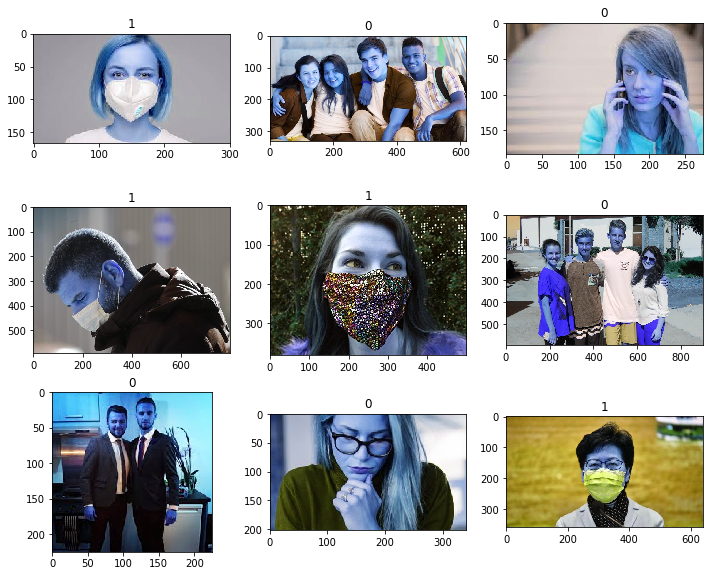

In [12]:
#Training images
nrows = 3
rands = np.random.randint(len(train_images_list), size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(train.loc[rands[i], 'file_name'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
    plt.title(train.loc[rands[i], 'target'])
plt.show()

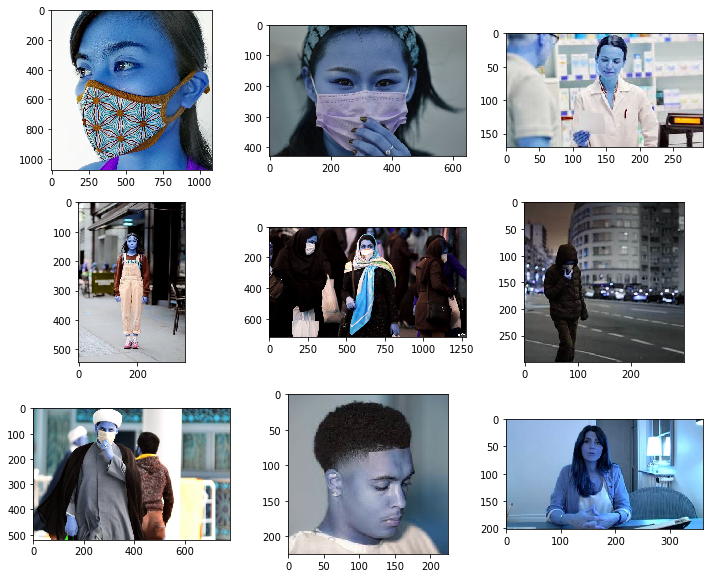

In [13]:
#Test images
nrows = 3
rands = np.random.randint(len(test_images_list), size=nrows**2)
fig = plt.figure(figsize=(12,10))

for i in range(nrows**2):
    img = cv2.imread(sub.loc[rands[i], 'file_name'])
    ax = plt.subplot(nrows, nrows, i+1)
    plt.imshow(img)
plt.show()

# The Torch way
## Training

For the training part, we are going to implement the well known <span style="color:red"> corss-validation</span> technique of K-Fold. So we tried our experiments with 10 folds.

In [14]:
n_folds = 10 # number of folds used

train['fold'] = 0

#creating our folds using a special class of Scikit-learn
fold = StratifiedKFold(n_splits = n_folds, random_state=seed)

for i, (tr, vr) in enumerate(fold.split(train, train['target'])):
    train.loc[vr, 'fold'] = i

In [ ]:
epochs = 15                # training epochs
device = 'cuda'            # in order to run model on GPU
size = (300, 300)          # image size
arch = 'densenet161'       # pre-trained model architecture used
layer = 'classifier'
fc_size = 2208             # Fully connected layer size
bs = 32                    # training Batch size
eval_bs = 4                # Evaluation Batch size
lr = 1e-4                  # learning rate


avg_logloss = 0        # variable for getting the average of loss results after training
best_fold = 0          # variable for getting the best fold number after training    
fold_logloss = np.inf  # initialize fold loss to infinity


######################################  TRAINING PART ###################################
# run training loop over our 10 folds

for fold in range(n_folds):
    _score = run_fold(fold, 
                      bs=bs, 
                      eval_bs=eval_bs, 
                      arch=arch, 
                      layer=layer, 
                      fc_size=fc_size, 
                      size=size, 
                      lr=lr)
    
    avg_logloss += _score

    if fold_logloss > _score:
        fold_logloss = _score
        best_fold = fold

######################################  TRAINING PART ###################################
        

print("\n [INFO] Avg LogLoss: ", avg_logloss/n_folds)

## Loading trained model for predictions
   * Load model (1)
   * Make prediction (2)
   * Create submission file (3)
   

In [0]:
# 1
MODELS = load_models(arch=arch, layer=layer, fc_size=fc_size)

# 2
predictions_labels, predictions_proba = predict(sub, size=size, MODELS=MODELS, bs=2)

## Making a submission

In [0]:
submission = pd.DataFrame()
submission['id'] = sub['image']
for i, label in enumerate(["0", "1"]):
    submission[label] = 0
for i, label in enumerate(["0", "1"]):
    submission.loc[:,label] = np.array(predictions_proba)[:,i]
submission['target'] = predictions_labels

#show predicted values
submission.head()

In [0]:
# Format dataframe to match Zindi sample submission file 
# and use experiment variables to keep relevant infos on it
subs = submission[['id', '1']]
subs.columns = ['id', 'target']
subs.to_csv(f'spot_{arch}_folds_{n_folds}_epochs_{epochs}_size_{size}_LR_{lr}.csv', index=False)

In [ ]:
y_true = submission['target'].to_list()
y_true = np.array(y_true)

y_pred = submission['1'].to_list()
y_pred = np.array(y_pred)

ll = log_loss(y_true=y_true, y_pred=y_pred)
print("[INFO] Your LogLoss score is {}".format(ll))

### Authors 

<table > 
    <thead>
        <tr> 
            <td>Name</td>
             <td>Zindi ID</td>
        </tr>
    </thead>
    <tbody> 
        <tr> 
            <td><span style='color:green'> Muhamed TUO </span> </td>
             <td>@Nazario</td>
        </tr>
        <tr> 
            <td><span style='color:green'> Cedric MANOUAN </span></td>
             <td>@Zeus</td>
        </tr>
        <tr> 
            <td><span style='color:green'> Emmanuel KOUPOH </span> </td>
             <td>@eaedk</td>
        </tr>
    </tbody>
</table>

